In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import theano.tensor as T
import pymc3 as pm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

//anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #9
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 7th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Question 1. Separate the Bayesian Irises

The goal of this problem is to introduce you to the idea of classification 
using Bayesian inferences. 

You are given the famous *Fisher flower Iris data set*
which is a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis.
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict
the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](iris.txt).

Lets $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is a 5D vector corresponding to an offset 1 and
the four components explained above. $Y \in \{0,1\}$ are the scalar 
labels of a class. In other words  
the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features, petal length
and width, sepal length and width, along with the offset, are your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Other Hints: also use theano.tensor.exp when you define the inerse logit to go from $\beta$ to $p$, and you might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).

Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. ( See the docs for scikit-learn's `train_test_split`).

## Part A: Sampling

1. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the normalized posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.
2. Find the MAP and mean estimate for the posterior on the training set.
3. Implement a  sampler to sample from this posterior of $\beta$.   Generate samples of $\beta$ and plot the sequence of $\beta$'s  and histograms for each $\beta$ component.
4. Use both the MAP and MEAN estimate of $\beta$, and the posterior distribution of $\beta$, to generate a set of probabilities and a set of posterior distributions respectively, for each data point $x$ in the training set. Plot the posterior against the MAP and MEAN estimate for 2 or 3 of your data points, preferably those with MAP estimates closer to 0.5.

$$ \beta  \sim N(0,\sigma^2I)
$$

$$p(\beta|Y,X) = \frac{p(Y,X|\beta)p(\beta)}{p(Y,X)}$$

$$ p(\beta|Y,X) = \frac{p(Y,X|\beta)p(\beta)}{\int p(Y,X|\beta)d\beta} $$


$$p(\beta|Y,X) \propto \left [ \prod_{i=1}^{n} \left ( \frac{1}{1+e^{-x_{i}^T \beta}} \right ) ^{y_i} \left (1-\frac{1}{1+e^{-x_{i}^T \beta}} \right )^{(1-y_i)} \right ] * N(0,\sigma^2I)
  $$
  
  

In [2]:
# load and format data
iris_data = pd.read_csv('./iris.txt')
iris_data['class'] = iris_data['class'].str.strip()
iris_data['y'] = np.zeros((iris_data.shape[0], 1))
iris_data['y'][iris_data['class'] != 'Iris-virginica'] = 1

//anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
iris_data.tail()

,sepal_length,sepal_width,petal_length,petal_width,class,y
145,6.7,3.0,5.2,2.3,Iris-virginica,0.0
146,6.3,2.5,5.0,1.9,Iris-virginica,0.0
147,6.5,3.0,5.2,2.0,Iris-virginica,0.0
148,6.2,3.4,5.4,2.3,Iris-virginica,0.0
149,5.9,3.0,5.1,1.8,Iris-virginica,0.0


In [4]:
# extract predictors
x_preds = np.array(iris_data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values)
x = np.concatenate([np.ones((iris_data.shape[0], 1)), x_preds], axis=1)
y = iris_data['y'].values

In [5]:
# split into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0, stratify=y)

In [6]:
# implement sampler
with pm.Model() as model:
    #beta 5 element vector 
    bta = pm.Normal('beta', mu=0, sd=10,shape=5) 
    #Logit
    p = pm.Deterministic('p', 1/(1 + T.exp(-T.dot(X_train,bta))))
    #Likelihood
    yhat = pm.Bernoulli("yhat", p, observed=y_train)
    #Sample from the posterior

In [7]:
# sample 10000 times
with model:
    trace = pm.sample(10000, pm.NUTS(), progressbar=True)

//anaconda/envs/python3/lib/python3.6/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 10000/10000 [00:59<00:00, 167.03it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115789a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1160d61d0>]], dtype=object)

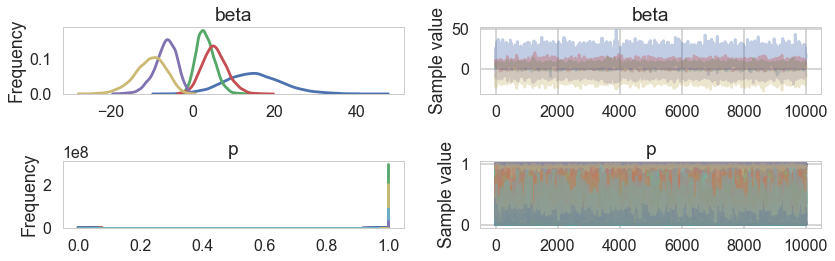

In [8]:
# plot the traces
pm.traceplot(trace)

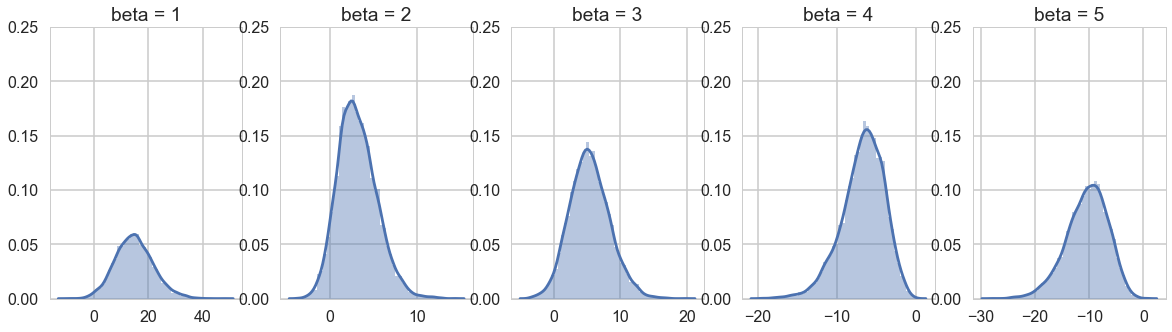

In [9]:
# plot histograms of beta from all 10000 traces 
plt.figure(figsize=(20,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    g = sns.distplot(trace['beta'][:,i])
    g.set(ylim=(0, 0.25))
    plt.title('beta = {}'.format(i+1))

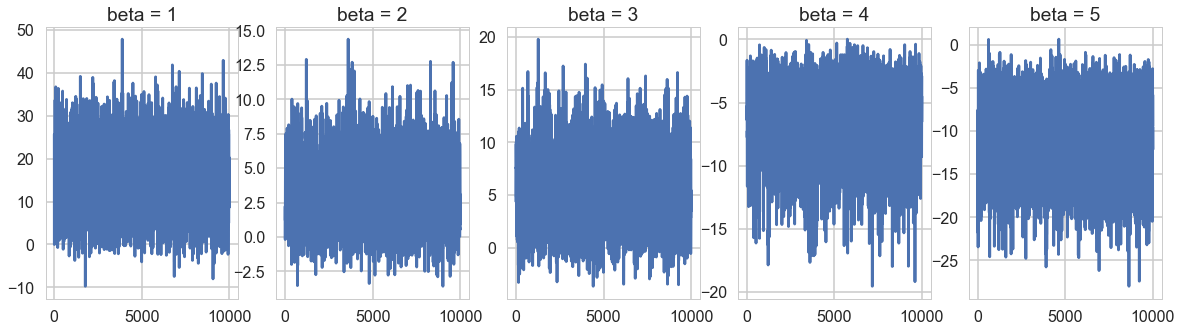

In [10]:
# plot the traces of beta to check for mixing 
plt.figure(figsize=(20,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(trace['beta'][:,i])
    plt.title('beta = {}'.format(i+1))

### Use both the MAP and MEAN estimate of  $\beta$ , and the posterior distribution of  $\beta$ , to generate a set of probabilities and a set of posterior distributions respectively, for each data point  $x$  in the training set. Plot the posterior against the MAP and MEAN estimate for 2 or 3 of your data points, preferably those with MAP estimates closer to 0.5

In [11]:
# MAP estimate
map_beta = pm.find_MAP(model=model)['beta']
# Mean estimate 
mean_beta = np.mean(trace['beta'], axis=0)
print('MAP beta ', map_beta)
print('MEAN beta ', mean_beta)

Optimization terminated successfully.
         Current function value: 24.201073
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
MAP beta  [ 12.3049244    2.21327356   4.26234353  -4.91717007  -8.47024323]
MEAN beta  [ 14.86261634   3.18301594   5.39551592  -6.66811209 -10.42717899]


In [12]:
invlogit = lambda X, betas: 1./(1.+np.exp(-X.dot(betas)) )
p_MAP= invlogit(X_train, map_beta)
p_MEAN= invlogit(X_train, mean_beta)
close_to_half_map = np.argsort(np.abs(np.array(p_MAP)-0.5))[:5]
close_to_half_mean = np.argsort(np.abs(np.array(p_MEAN)-0.5))[:5]

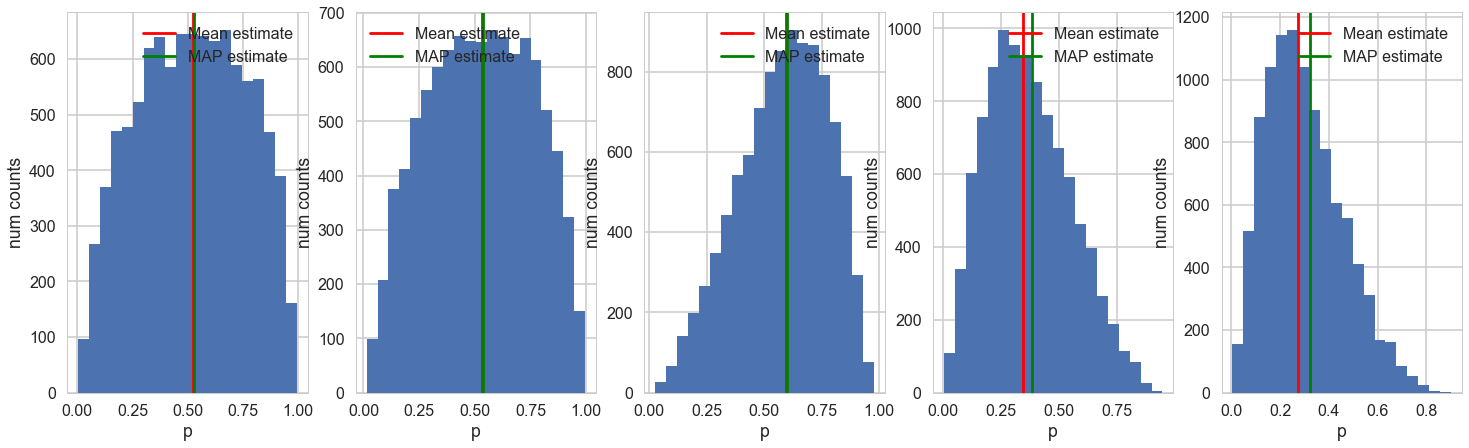

In [13]:
plt.figure(figsize=(25,7))
for inx, i in enumerate(close_to_half_map):
    plt.subplot(1, 5, inx+1)
    X = X_train[i,:]
    probs = trace['p'][:,i]
    plt.hist(probs, bins=20)
    plt.xlabel('p')
    plt.ylabel('num counts')
    plt.axvline(x=invlogit(X, mean_beta), color='red', label='Mean estimate')
    plt.axvline(x=invlogit(X, map_beta), color='green', label='MAP estimate')
    plt.legend(loc='best')
    

There are a few samples in the training set which have MAP probabilities close to 0.5. These 'uncertain' points could be classified either as a 1 or 0. However it is interesting to note that only the top two uncertain points have approximately symmetric distributions about 0.5, and the subsequent uncertain points start to show skewed behaviour (skew towards 0 or 1). 

---

Now that we have both point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

**There are two ways to make these predictions, given an estimate of $p(y=1 \vert x)$ **: 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

**And there are multiple ways in which you can do these probability estimates at a sample $x$**:

(A) You could just use the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

(C) Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

## Part B: Playing with Probabilities

1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?
 



In [14]:
# pmean
probs_mean = []
for i in range(X_train.shape[0]):
    X = X_train[i,:]
    probs_mean.append(invlogit(X, mean_beta))
    
# pcdf
pcdf = np.mean(trace['p']>0.5,axis=0)

# ppp
probs_pp = []
for i in range(X_train.shape[0]):
    ps = trace['p'][:,i]
    pp_samples = stats.bernoulli.rvs(ps)
    probs_pp.append(pp_samples.mean())

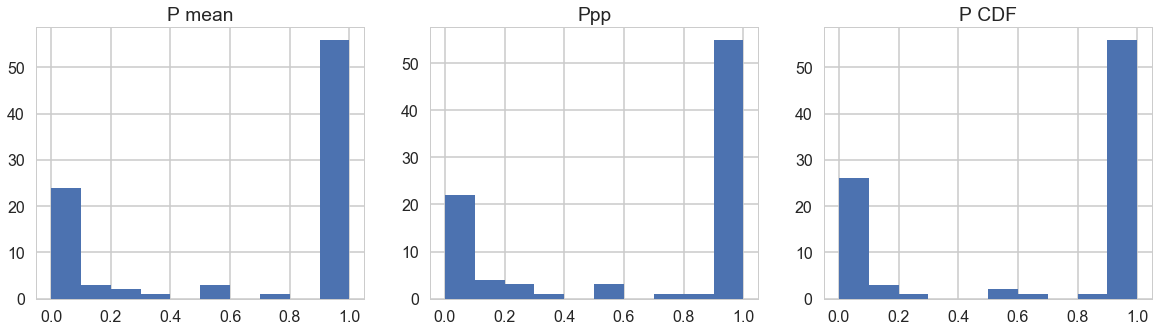

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(probs_mean, bins=10)
plt.title('P mean')
plt.subplot(1,3,2)
plt.hist(probs_pp, bins=10)
plt.title('Ppp')
plt.subplot(1,3,3)
plt.hist(pcdf, bins=10)
plt.title('P CDF')

The distributions are all very similar but with Ppp there is slightly higher density in the interval between 0 and 1, whereas with Pcdf and P mean there is slighty higher density at the edges.  

### Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.

### Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the  p>0.5⟹y=1p>0.5⟹y=1  decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution?

In [16]:
# posterior predictive misclassification rate
y_sample = stats.bernoulli.rvs(trace['p'])
misclassification_rates_posterior_predictive = []
for i in range(y_sample.shape[0]):
    compare = y_sample[i,:] != y_train
    misclassification_rates_posterior_predictive.append(compare.mean())

In [17]:
# MLDT misclassification rate
score = np.apply_along_axis(lambda x: x > 0.5, 0, trace['p'])
misclassification_rates_posterior = []
for i in range(y_sample.shape[0]):
    compare = score[i,:]*1 != y_train
    misclassification_rates_posterior.append(compare.mean())

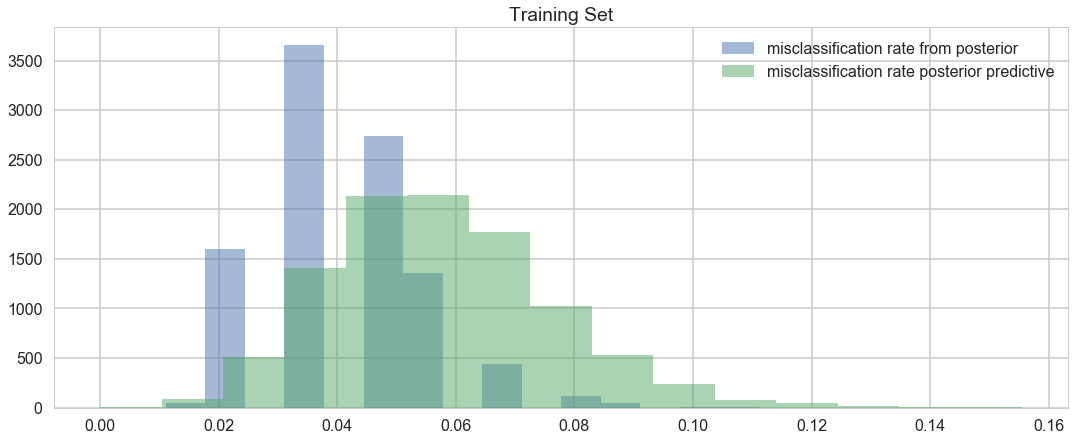

In [21]:
plt.figure(figsize=(40,7))
plt.subplot(1,2,1)
plt.title('Training Set')
plt.hist(misclassification_rates_posterior, bins=15, alpha=0.5, label='misclassification rate from posterior')
plt.hist(misclassification_rates_posterior_predictive, alpha=0.5,bins=15, label='misclassification rate posterior predictive')
plt.legend(loc='best')
plt.show()

The posterior is more peaked and posterio predictive which has a wider and flatter misclassification distribution. This is the smearing effect we expected. 

### Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.

In [22]:
trace_results = {}
for i in range(np.shape(y_sample)[0]):
    sample = ''.join([str(e) for e in list(y_sample[i, :])])
    bitstring = ''.join(sample)
    if bitstring not in trace_results:
        trace_results[bitstring] = 1
    else:
        trace_results[bitstring] += 1
y_train_bitstring = ''.join([str(int(e)) for e in list(y_train)])
print('Posterior predictive : number of times correct classification is achieved in the trace: ', trace_results[y_train_bitstring])

Posterior predictive : number of times correct classification is achieved in the trace:  3


In [23]:
score = score *1
trace_results_posterior = {}
for i in range(np.shape(y_sample)[0]):
    sample = ''.join([str(e) for e in list(score[i, :])])
    bitstring = ''.join(sample)
    if bitstring not in trace_results_posterior:
        trace_results_posterior[bitstring] = 1
    else:
        trace_results_posterior[bitstring] += 1
y_train_bitstring = ''.join([str(int(e)) for e in list(y_train)])
try:
    successes = trace_results_posterior[y_train_bitstring]
except KeyError:
    successes = 0
# occurs 0 times c
print('Posterior: number of times correct classification is achieved in the trace: ', successes)

Posterior: number of times correct classification is achieved in the trace:  0


In [24]:
post_sorted = sorted(trace_results_posterior.items(), key=lambda x: x[1], reverse=True)
post_pred_sorted = sorted(trace_results.items(), key=lambda x: x[1],reverse=True)

In [25]:
post_sorted[:2]

[('111010111111100101111111100101111011000110110111101110111010110111111000001101001111000110',
  1098),
 ('111010111111000101111111100101110011000110110111101111111010110111111000001101001111000110',
  692)]

In [26]:
post_pred_sorted[:3]

[('111010111111100101111111100101111011000110110111101110111010110111111000001101001111000110',
  114),
 ('111010111111000101111111100101110011000110110111101111111010110111111000001101001111000110',
  93),
 ('111010111111000101111111100101111011000110110111101111111010110111111000001101001111000110',
  92)]

The true outcome distribution is only obtained 6 times when considering the posterior predictive probabilities and is not obtained at all when considering the posterior probabilities. 

The posterior is more peaked than the posterior predictive (most frequent traces occur with larger counts in posterior traces than posterior predictive). With the posterior predictive the distribution of trace outcomes appears flatter with the most frequent bitstring only accounting for 1% compared to the most frequent in the posterior accounting for 10%. 

### Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?

In [27]:
# testing set posterior probabilities 
n_test = X_test.shape[0]
p_test = np.zeros((10000, n_test))

for i in range(n_test):
    for j, bta in enumerate(trace['beta']):
        p_test[j, i] = invlogit(X_test[i,:], bta)

In [28]:
# posterior pred score:
y_sample_test = stats.bernoulli.rvs(p_test)
misclassification_rates_posterior_predictive_test = []
for i in range(y_sample.shape[0]):
    compare = y_sample_test[i,:] != y_test
    misclassification_rates_posterior_predictive_test.append(compare.mean())

In [29]:
# MLDT score posterior
score_test = np.apply_along_axis(lambda x: x > 0.5, 0, p_test)
misclassification_rates_posterior_test = []
for i in range(y_sample.shape[0]):
    compare = score_test[i,:]*1 != y_test
    misclassification_rates_posterior_test.append(compare.mean())

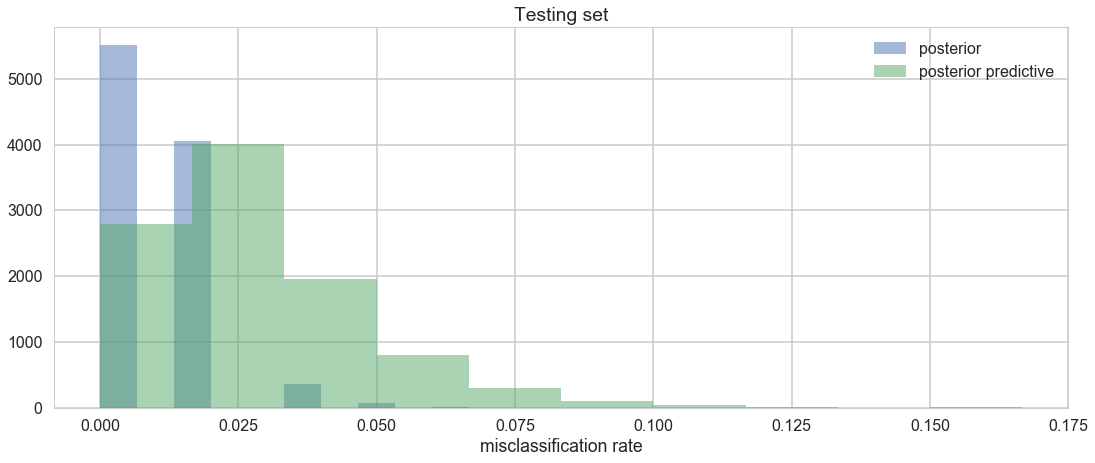

In [32]:
plt.figure(figsize=(40,7))
plt.subplot(1,2,1)
plt.title('Testing set')
plt.xlabel('misclassification rate')
plt.hist(misclassification_rates_posterior_test, alpha = 0.5, bins=10, label='posterior')
plt.hist(misclassification_rates_posterior_predictive_test,  alpha = 0.5,bins=10, label='posterior predictive')
plt.legend(loc='best')
plt.show()

The width of the distribution is again wider for the posterior predictive than the posterior.

## Extra Credit: Deriving the MLDT

If you took a distribution of prediction to your boss, he/she would probably ask you to make a choice. Decision Theory is the right way to make such a choice, rather than choosing an arbitrary set of bernoulli samplings. The idea is to minimize the posterior 
predictive averaged decision risk at each sample $x$:

$$R(g, x) = \int dy P(y \vert x) R(g, y \vert x) = \sum_{y=0,1} P(y \vert x) R(g, y \vert x)$$

where $g$ is the action you take: classify as 1 or 0. Use $R(g, y \vert x) = {\mathbb 1}_{g \ne y} \forall x$, the 1-0 loss.

1. Show that if $R(1, x) <= R(0, x)$ and thus we choose 1 as our classification, $p(1 \vert x) >= 0.5$. 
2. Use this MLDT rule and probabilities from both $p_{CDF}$ and $p_{PP}$ to make two classifications on the training set and test set. What is the misclassification rate in both? WHy do you think this is the case? 

\begin{aligned}
R(0, x) = P(0|x)R(0, 0|x) + P(1|x)R(0, 1|x)\\ 
    \newline
R(1, x) = P(0|x)R(1, 0|x) + P(1|x)R(1, 1|x)
\end{aligned}

As R is a 1-0 loss, the following simplifications can be made:

\begin{aligned}
R(0, x) = P(1|x)\\ 
    \newline
R(1, x) = P(0|x)
\end{aligned}

Now considering the inequality $R(1, x) <= R(0, x)$, the appropriate expression for $P$ can be substituted in:

$$ P(0|x) <= P(1|x)$$

Noting that $ P(0|x) + P(1|x) = 1 $, we arrive at the final result:

$$p(1 \vert x) >= 0.5$$


In [33]:
# training set:
pcdf_train_preds = pcdf>0.5
pcdf_train_preds = pcdf_train_preds*1

In [34]:
# testing set posterior probabilities 
n_test = X_test.shape[0]
p_test = np.zeros((10000, n_test))

for i in range(n_test):
    for j, bta in enumerate(trace['beta']):
        p_test[j, i] = invlogit(X_test[i,:], bta)

In [49]:
pcdf_test = np.mean(p_test>0.5,axis=0)
pcdf_test_predictions = pcdf_test>0.5
pcdf_test_predictions = pcdf_test_predictions*1

In [50]:
# training set
probs_pp = []
for i in range(X_train.shape[0]):
    ps = trace['p'][:,i]
    pp_samples = stats.bernoulli.rvs(ps)
    probs_pp.append(pp_samples.mean())
probs_pp = np.array(probs_pp)

In [51]:
# testing set
probs_pp_test = []
for i in range(X_test.shape[0]):
    ps = p_test[:,i]
    pp_samples_test = stats.bernoulli.rvs(ps)
    probs_pp_test.append(pp_samples_test.mean())
probs_pp_test = np.array(probs_pp_test)

In [52]:
misclassification_rates_train = np.mean(pcdf_train_preds != y_train)
print('train pcdf  misclassification ', misclassification_rates_train)

misclassification_rates_test = np.mean(pcdf_test_predictions != y_test)
print('test pcdf misclassification ', misclassification_rates_test)

train pcdf  misclassification  0.0222222222222
test pcdf misclassification  0.0


In [53]:
probs_pp_preds_train = probs_pp>0.5
probs_pp_preds_train = probs_pp_preds_train*1
misclassification_rates_train_pp = np.mean(probs_pp_preds_train != y_train)
print('train pp  misclassification ', misclassification_rates_train_pp)

probs_pp_preds_test = probs_pp_test>0.5
probs_pp_preds_test = probs_pp_preds_test*1
misclassification_rates_test_pp = np.mean(probs_pp_preds_test != y_test)
print('test pp  misclassification ', misclassification_rates_test_pp)

train pp  misclassification  0.0222222222222
test pp  misclassification  0.0


The misclassification rates from the posterior and posterior predictive are exactly the same for the testing set. A similar observation can be made about the training set. The output probabilities from both methods are very similar hence it is unsurprising that the misclassification rates are similar. 

The misclassification rate is very low for the training set however it is suprising however that the misclassification rate on the testing set is 0. 